In [ ]:
pip install umap-learn

  Using cached numpy-1.21.6-cp39-cp39-win_amd64.whl (14.0 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\navee\\anaconda3\\Lib\\site-packages\\numpy\\~-ibs\\libopenblas64__v0.3.21-gcc_10_3_0.dll'
Consider using the `--user` option or check the permissions.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from keras.layers import Resizing
from keras.datasets import cifar10
from keras.utils import to_categorical, set_random_seed

In [ ]:
# remove this cell before posting
from keras.applications import MobileNetV2
from keras.models import Model, Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dense, Input, BatchNormalization, Activation, Dropout

In [ ]:
# https://keras.io/examples/keras_recipes/reproducibility_recipes/

# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
set_random_seed(0)

In [ ]:
def subsample(X, y=None, p=0.1):
    # work with a fraction of the data
    n_samples = X.shape[0]
    subsample_size = int(n_samples * p)
    idxs = np.random.choice(n_samples, subsample_size, replace=False)
    if y is None:
        return X[idxs]
    else:
        return X[idxs], y[idxs]

def visualise_embedding(X, y=None, p_subsample=None):
    """
    Visualise an embedding X as a scatterplot.

    Optionally visualise class labels y at the same time as colours.

    If X has >2 dimensions, use UMAP to reduce to 2.

    User can supply eg subsample=0.01, to show a small fraction of the data.
    """
    n_samples, n_features = X.shape

    # check X and y shapes compatible
    if y is not None:
        if n_samples != y.shape[0]:
            raise ValueError(f"X and y have incompatible shapes {X.shape} and {y.shape}")

        if len(y.shape) == 2:
            # these are probably one-hot encoded, so convert to integer
            y = np.argmax(y, axis=1)

    # work with only a fraction of the data
    if p_subsample is not None:
        if y is None:
            X = subsample(X, p_subsample)
        else:
            X, y = subsample(X, y, p_subsample)

    # ensure we have 2 dimensions, using UMAP for dim reduction if needed
    if n_features > 2:
        import umap # pip install umap-learn
        reducer = umap.UMAP()
        X = StandardScaler().fit_transform(X) # need all dimensions to be on approx same scale
        X = reducer.fit_transform(X) # UMAP reduce to 2D

    # Visualization
    colors = plt.get_cmap('tab10')  # Get a color map with 10 distinct colors

    plt.figure(figsize=(10, 8))
    for i in range(10): # for 10 classes in CIFAR-10
        indices = np.where(y == i)
        plt.scatter(X[indices, 0], X[indices, 1], label=f'Class {i}', color=colors(i))

    # reflect the dim reduction in axis labels if needed
    if n_features == 2:
        axis0_lab = "z0"
        axis1_lab = "z1"
    else:
        axis0_lab = "UMAP0"
        axis1_lab = "UMAP1"

    plt.legend()
    plt.xlabel(axis0_lab)
    plt.ylabel(axis1_lab)
    plt.show()

In [ ]:
# Load CIFAR-10 data
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train.shape

(50000, 32, 32, 3)

We will take 50% of the data.

In [ ]:
# keep only a small amount of the training data for fast prototyping
# later, we could train on all data, by commenting out this line
x_train, y_train = subsample(x_train, y_train, 0.5)

# convert image data to float16 to save some memory
x_train = x_train.astype('float16')
x_test = x_test.astype('float16')

# normalise X
x_train, x_test = x_train / 255.0, x_test / 255.0
# one-hot encode y
y_train, y_test = to_categorical(y_train, 10), to_categorical(y_test, 10)

In [ ]:
# some pretrained models require a specific image *size*.
# if needed, we can use code like this to make a resized version of the images

resizing_layer = Resizing(96, 96) # a resizing layer can work on its own, doesn't have to be part of a model
x_train_96px = resizing_layer(x_train)
x_test_96px = resizing_layer(x_test)

Per Karpathy: look at your data! And make sure to look at it immediately before training, after any preprocessing, in case of preprocessing bugs. You want to see exactly what the network will see. (Unfortunately we have to give a `float32` to keep Matplotlib `imshow` happy.)

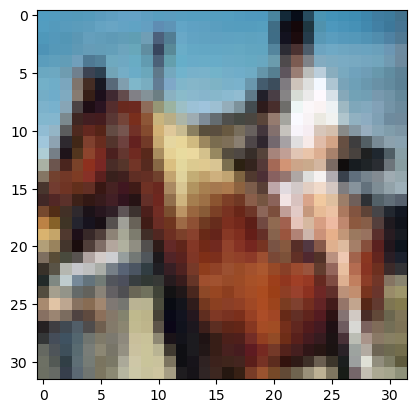

In [ ]:
plt.imshow(x_train[0].astype('float32'));

## Reference
The above code is taken from:
Dr. James McDermott (Lecturer in Computer Science at University of Galway)

# Introduction

We will start off by importing the necessary libraries and a base convolutional neural network model (`cnn_model`) is defined as a function, with `z` neurons in the penultimate layer. Different refinements have been tried with `z` being 2 and 10, adding extra convolutional layers and adding extra dense layers, different optimizers and also utilizing dropouts and padding.  

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

Below the base convolutional neural network model `cnn_model` is defined. Two convolutional layers (with 64 filters each and filter shape = (3,3)) and two max pooling layers (with the shape (2,2)) is defined. The activation used is `relu`. Then the input is flattened. There are three Dense layers (one with 128 neurons, other with `z` neurons and finally the output layer with 10 neurons for 10 classes with the activation of `softmax`)

# Model Building

In [ ]:
def cnn_model(z):
    model = Sequential([
        Conv2D(64, (3, 3), activation = 'relu', input_shape = (32, 32, 3)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation = 'relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation = 'relu'),
        Dense(z, activation = 'relu'),
        Dense(10, activation = 'softmax')
    ])
    return model

`z` is set to be 2. I have used the `adam` optimiser and `categorical_crossentropy` as the loss. The metrics used here is `accuracy`. The `visualise_embedding` function is then used to visualise the embeddings of the penultimate layer.

# Model 1
### Adam Optimizer and  z = 2


In [ ]:
model = cnn_model(2)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 128)               2

The pixels in the four corners will be excluded when the convolutional filters are applied. So we will start with the image size of 30x30. Two `conv2d` layers are `max_pooling2d` has been applied. Resultant image is 6x6, which is shrinked from 30x30.

Epoch 1/20
782/782 [==============================] - 19s 23ms/step - loss: 2.3028 - accuracy: 0.1017 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 2/20
782/782 [==============================] - 19s 25ms/step - loss: 2.3027 - accuracy: 0.1035 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 3/20
782/782 [==============================] - 24s 30ms/step - loss: 2.3027 - accuracy: 0.1042 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 4/20
782/782 [==============================] - 24s 30ms/step - loss: 2.3027 - accuracy: 0.1042 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 5/20
782/782 [==============================] - 23s 29ms/step - loss: 2.3027 - accuracy: 0.1042 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 6/20
782/782 [==============================] - 22s 29ms/step - loss: 2.3027 - accuracy: 0.1042 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 7/20
782/782 [==============================] - 23s 29ms/step - loss: 2.3027 - accuracy: 0.1042 - val_loss: 2.3027 - val_accuracy:

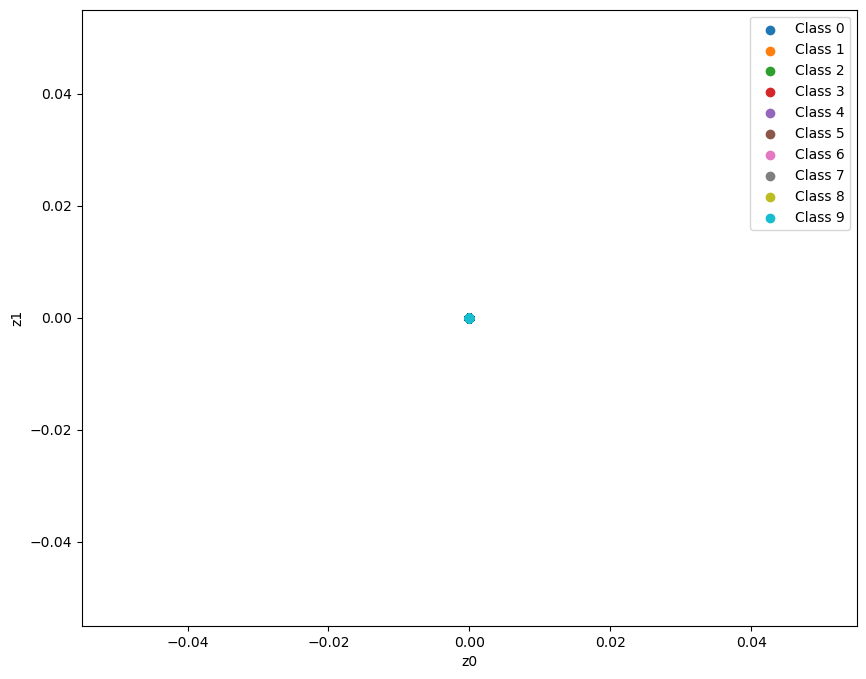

In [ ]:
history = model.fit(x_train, y_train, epochs = 20, batch_size = 32, validation_data = (x_test, y_test))
test_loss, test_acc = model.evaluate(x_test, y_test, verbose = 1)
print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_acc)
penultimate_model = Model(inputs = model.input, outputs = model.layers[-2].output)
visualise_embedding(penultimate_model.predict(x_train), y = y_train)

The model was ran for 20 epochs and the results are quite bad. After the 2nd epoch there is no learning happening in the training set and the validation accuracy is constant since the beginning. The accuracy on both the training and the validation data is significantly low. Training for higher epochs doesn't seem to be an ideal option because as mentioned earlier, there is no significant increase in the accuracy. Adding to the point of model's poor performance is the embedding plot that we can see. Clearly, the model is finding it difficult to differentiate the classes and all we can see is a single point representing class 9 and eventhough `adam` adapts the learning rate during training rate, the intial learning rate might have been too high leading for the model to not converge. The model is also not complex enough to learn about the data, the archictecture isn't too big.

# Model 1
### Adam Optimizer and `z` = 10

In [ ]:
model = cnn_model(10)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 128)               2

Same settings, with `z` = 10

Epoch 1/20
782/782 [==============================] - 30s 36ms/step - loss: 2.3029 - accuracy: 0.1024 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 2/20
782/782 [==============================] - 28s 35ms/step - loss: 2.3027 - accuracy: 0.1042 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 3/20
782/782 [==============================] - 28s 36ms/step - loss: 2.3027 - accuracy: 0.1042 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 4/20
782/782 [==============================] - 28s 36ms/step - loss: 2.3027 - accuracy: 0.1042 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 5/20
782/782 [==============================] - 27s 34ms/step - loss: 2.3027 - accuracy: 0.1042 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 6/20
782/782 [==============================] - 28s 35ms/step - loss: 2.3027 - accuracy: 0.1042 - val_loss: 2.3027 - val_accuracy: 0.1000
Epoch 7/20
782/782 [==============================] - 27s 35ms/step - loss: 2.3027 - accuracy: 0.1042 - val_loss: 2.3027 - val_accuracy:

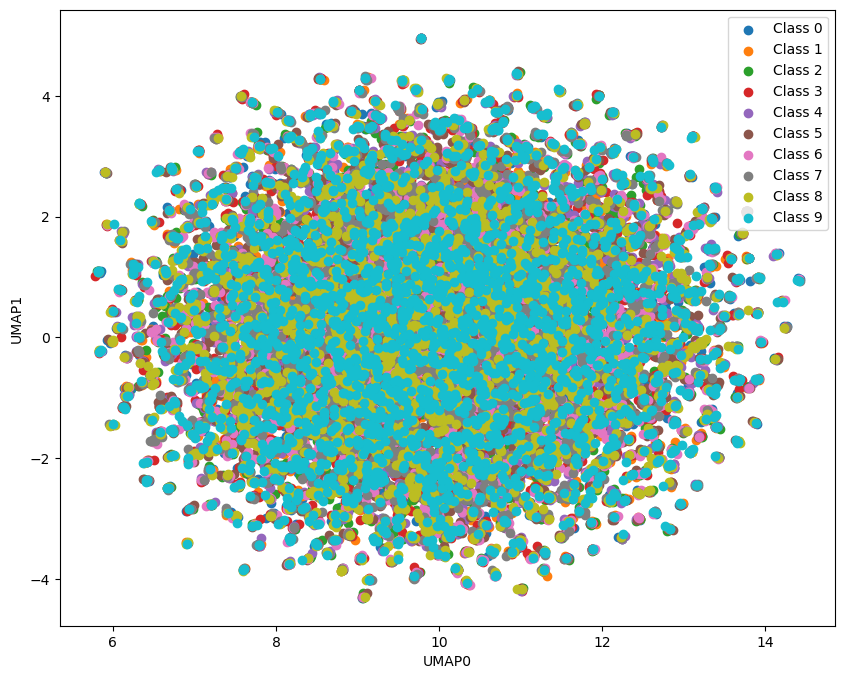

In [ ]:
history = model.fit(x_train, y_train, epochs = 20, batch_size = 32, validation_data = (x_test, y_test))
test_loss, test_acc = model.evaluate(x_test, y_test, verbose = 1)
print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_acc)
penultimate_model = Model(inputs = model.input, outputs = model.layers[-2].output)
visualise_embedding(penultimate_model.predict(x_train), y = y_train)

Now, the embeddings is visible. But there is a tons of overlapping. The model is not able to differentiate the classes.

# Model 1
### SGD Optimizer and `z` = 2

In [ ]:
model = cnn_model(2)
model.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 2304)              0         
                                                                 
 dense_3 (Dense)             (None, 128)              

Same settings except, the optimizer is changed to `sgd`

Epoch 1/20
782/782 [==============================] - 64s 80ms/step - loss: 2.2892 - accuracy: 0.1404 - val_loss: 2.2768 - val_accuracy: 0.1236
Epoch 2/20
782/782 [==============================] - 66s 84ms/step - loss: 2.2481 - accuracy: 0.1520 - val_loss: 2.2303 - val_accuracy: 0.1678
Epoch 3/20
782/782 [==============================] - 65s 83ms/step - loss: 2.1812 - accuracy: 0.1755 - val_loss: 2.1424 - val_accuracy: 0.2197
Epoch 4/20
782/782 [==============================] - 65s 83ms/step - loss: 2.0762 - accuracy: 0.2198 - val_loss: 2.0256 - val_accuracy: 0.2328
Epoch 5/20
782/782 [==============================] - 64s 82ms/step - loss: 1.9544 - accuracy: 0.2540 - val_loss: 1.8802 - val_accuracy: 0.2700
Epoch 6/20
782/782 [==============================] - 65s 83ms/step - loss: 1.8632 - accuracy: 0.2699 - val_loss: 1.8395 - val_accuracy: 0.2593
Epoch 7/20
782/782 [==============================] - 65s 84ms/step - loss: 1.8064 - accuracy: 0.2863 - val_loss: 1.8569 - val_accuracy:

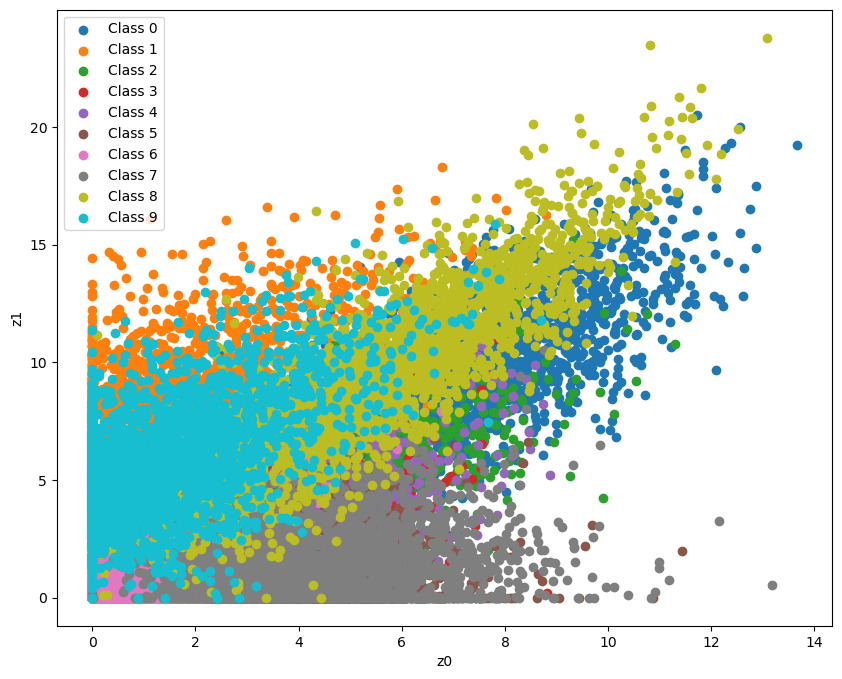

In [ ]:
history = model.fit(x_train, y_train, epochs = 20, batch_size = 32, validation_data = (x_test, y_test))
test_loss, test_acc = model.evaluate(x_test, y_test, verbose = 1)
print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_acc)
penultimate_model = Model(inputs = model.input, outputs = model.layers[-2].output)
visualise_embedding(penultimate_model.predict(x_train), y = y_train)

The embedding here is way better than the previous one. We can see the spread in the datapoints clearly suggesting that the model is able to learn something from the data and seggregate it. Though there is a spread in the datapoint, there is still a lot of overlapping happening. But this is a good improvement from the previous one as the only change made was using a different optimizer. While `adam` can adapt its learning rate, in certain cases it tends to overshoots, while `sgd` in this case seems to show an upper hand over `adam`

# Model 1
### SGD Optimizer and `z` = 10

In [ ]:
model = cnn_model(10)
model.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 30, 30, 64)        1792      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 2304)              0         
                                                                 
 dense_3 (Dense)             (None, 128)              

Epoch 1/20
782/782 [==============================] - 28s 34ms/step - loss: 2.2819 - accuracy: 0.1505 - val_loss: 2.2544 - val_accuracy: 0.1726
Epoch 2/20
782/782 [==============================] - 26s 33ms/step - loss: 2.1356 - accuracy: 0.2240 - val_loss: 2.0016 - val_accuracy: 0.2826
Epoch 3/20
782/782 [==============================] - 27s 34ms/step - loss: 1.9191 - accuracy: 0.2988 - val_loss: 1.8142 - val_accuracy: 0.3336
Epoch 4/20
782/782 [==============================] - 26s 34ms/step - loss: 1.7454 - accuracy: 0.3567 - val_loss: 1.6968 - val_accuracy: 0.3762
Epoch 5/20
782/782 [==============================] - 26s 33ms/step - loss: 1.6218 - accuracy: 0.4065 - val_loss: 1.5524 - val_accuracy: 0.4254
Epoch 6/20
782/782 [==============================] - 28s 35ms/step - loss: 1.5289 - accuracy: 0.4425 - val_loss: 1.5609 - val_accuracy: 0.4294
Epoch 7/20
782/782 [==============================] - 26s 33ms/step - loss: 1.4581 - accuracy: 0.4674 - val_loss: 1.8295 - val_accuracy:

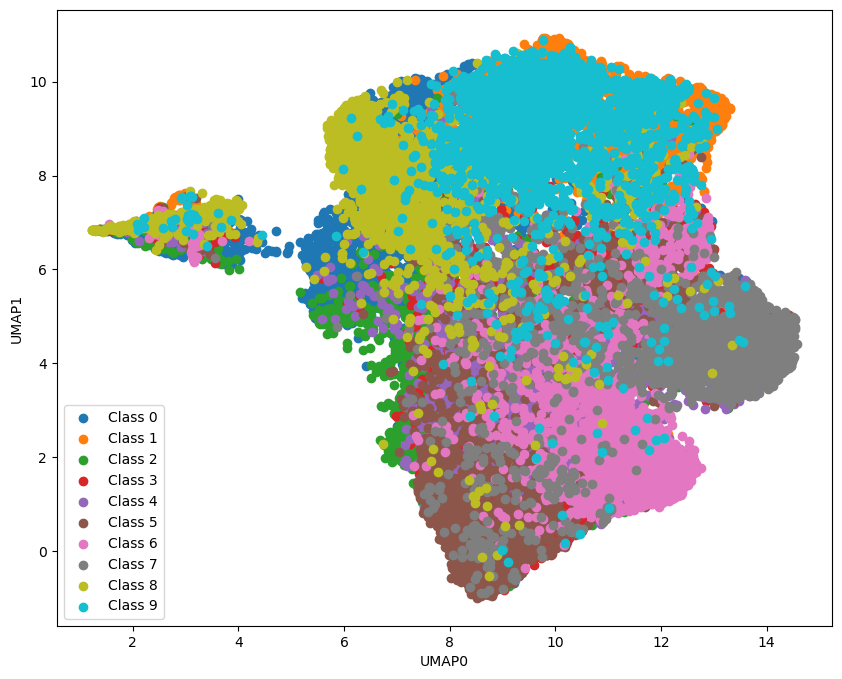

In [ ]:
history = model.fit(x_train, y_train, epochs = 20, batch_size = 32, validation_data = (x_test, y_test))
test_loss, test_acc = model.evaluate(x_test, y_test, verbose = 1)
print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_acc)
penultimate_model = Model(inputs = model.input, outputs = model.layers[-2].output)
visualise_embedding(penultimate_model.predict(x_train), y = y_train)

The model's performance has increased a bit. Still the overlapping is significant. As the epochs increases the model is performing good, clearly for each epoch there is some jumps happening but the learning is still increasing. So one of the options is training for more epochs which will result in better accuracy.

# Model 2
### CNN Model with extra layers and other refinements
We will stick with `sgd` as the optimizer. Some extra refinements has been made to the previous model. Refinements such as adding extra convolution layers, adding padding, adding dropouts and adding extra dense layers.

In [ ]:
def cnn_enhanced_model(z):
    model = Sequential([
        Conv2D(64, (3, 3), activation = 'relu', padding = 'same', input_shape = (32, 32, 3)),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        Conv2D(64, (3, 3), activation = 'relu', padding = 'same'),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation = 'relu', padding = 'same'),
        MaxPooling2D((2, 2)),
        Dropout(0.2),
        Conv2D(64, (3, 3), activation = 'relu', padding = 'same'),
        Flatten(),
        Dense(512, activation = 'relu'),
        Dense(228, activation = 'relu'),
        Dense(124, activation = 'relu'),
        Dense(64, activation = 'relu'),
        Dense(z, activation = 'relu'),
        Dense(10, activation = 'softmax')
    ])
    return model

# Model 2
### SGD Optimizer and `z` = 2

In [ ]:
model2 = cnn_enhanced_model(2)
model2.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 8, 8, 64)         

The model is refined with extra `conv2d`, `max_pooling2d` layers, dropouts and padding. With the help of padding the corner pixels are retained. Thus the final image is 4x4 from 32x32. The resultant image is quite small, but lets keep going to see what kind of results we are able to get.

Epoch 1/100
782/782 [==============================] - 51s 65ms/step - loss: 2.3009 - accuracy: 0.1164 - val_loss: 2.2973 - val_accuracy: 0.1377
Epoch 2/100
782/782 [==============================] - 51s 65ms/step - loss: 2.2883 - accuracy: 0.1320 - val_loss: 2.2664 - val_accuracy: 0.1486
Epoch 3/100
782/782 [==============================] - 49s 62ms/step - loss: 2.2092 - accuracy: 0.1513 - val_loss: 2.1223 - val_accuracy: 0.1724
Epoch 4/100
782/782 [==============================] - 50s 64ms/step - loss: 2.0771 - accuracy: 0.1836 - val_loss: 1.9982 - val_accuracy: 0.2272
Epoch 5/100
782/782 [==============================] - 49s 63ms/step - loss: 1.9818 - accuracy: 0.2177 - val_loss: 1.9138 - val_accuracy: 0.2405
Epoch 6/100
782/782 [==============================] - 50s 64ms/step - loss: 1.9191 - accuracy: 0.2412 - val_loss: 1.8606 - val_accuracy: 0.2475
Epoch 7/100
782/782 [==============================] - 50s 64ms/step - loss: 1.8694 - accuracy: 0.2540 - val_loss: 1.8738 - val_ac

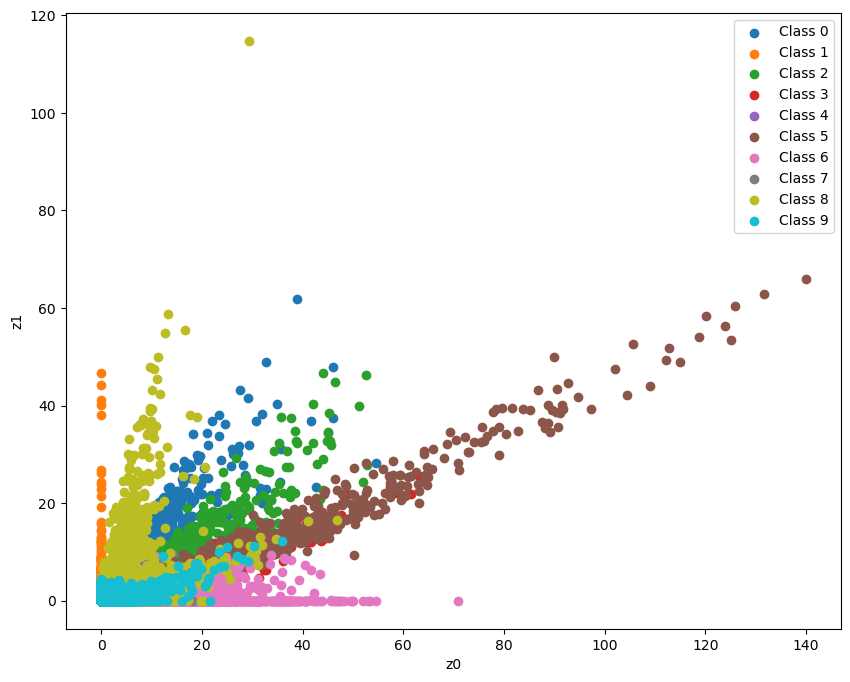

In [ ]:
#SGD with 100 epochs with z = 2
history = model2.fit(x_train, y_train, epochs = 100, batch_size = 32, validation_data = (x_test, y_test))
test_loss, test_acc = model2.evaluate(x_test, y_test, verbose = 1)
print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_acc)
penultimate_model = Model(inputs = model2.input, outputs = model2.layers[-2].output)
visualise_embedding(penultimate_model.predict(x_train), y = y_train)

After training the model for 100 epochs, we can see a huge drop in the validation accuracy in the last epoch. Beyond this huge drop in the last epoch, we can see a lot more of these jumping in between the training period. While there is not a huge jump happening in the training accuracy except for in certain epochs, when it comes to validation data, we can see a lot of jumps happening in between the epochs. Training for further more epochs will yet again might lead to more jumps. The embeddings are inclined towards left bottom corner and seems to spread diagonally and also in other directions. The colour representation tells that there did happen some learning as we can see some distinctiveness between the colours. Although overlapping is happening, this distinctiveness between colour suggests that some learning has happened. There is a significant improvement in the model's performance from the previous model. Now the training and validation accuracy despite being high, the model is performing poorly on the test data, as we can see, the accuracy is just 24%

# Model 2
###  SGD Optimizer and `z ` = 10

In [ ]:
#SGD with 50 epochs with z = 10
model2 = cnn_enhanced_model(10)
model2.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])
model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 16, 16, 64)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 16, 16, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 8, 8, 64)         

Again, same settings, except we are going to train the model with `z` = 10

Epoch 1/50
782/782 [==============================] - 49s 61ms/step - loss: 2.2998 - accuracy: 0.1182 - val_loss: 2.2921 - val_accuracy: 0.1328
Epoch 2/50
782/782 [==============================] - 49s 62ms/step - loss: 2.2492 - accuracy: 0.1506 - val_loss: 2.1637 - val_accuracy: 0.1857
Epoch 3/50
782/782 [==============================] - 50s 64ms/step - loss: 2.0782 - accuracy: 0.2360 - val_loss: 1.9903 - val_accuracy: 0.2549
Epoch 4/50
782/782 [==============================] - 49s 62ms/step - loss: 1.8810 - accuracy: 0.3043 - val_loss: 1.8111 - val_accuracy: 0.3371
Epoch 5/50
782/782 [==============================] - 48s 62ms/step - loss: 1.7314 - accuracy: 0.3604 - val_loss: 1.8254 - val_accuracy: 0.3247
Epoch 6/50
782/782 [==============================] - 50s 63ms/step - loss: 1.6351 - accuracy: 0.3992 - val_loss: 1.5806 - val_accuracy: 0.4042
Epoch 7/50
782/782 [==============================] - 48s 61ms/step - loss: 1.5556 - accuracy: 0.4281 - val_loss: 2.1597 - val_accuracy:

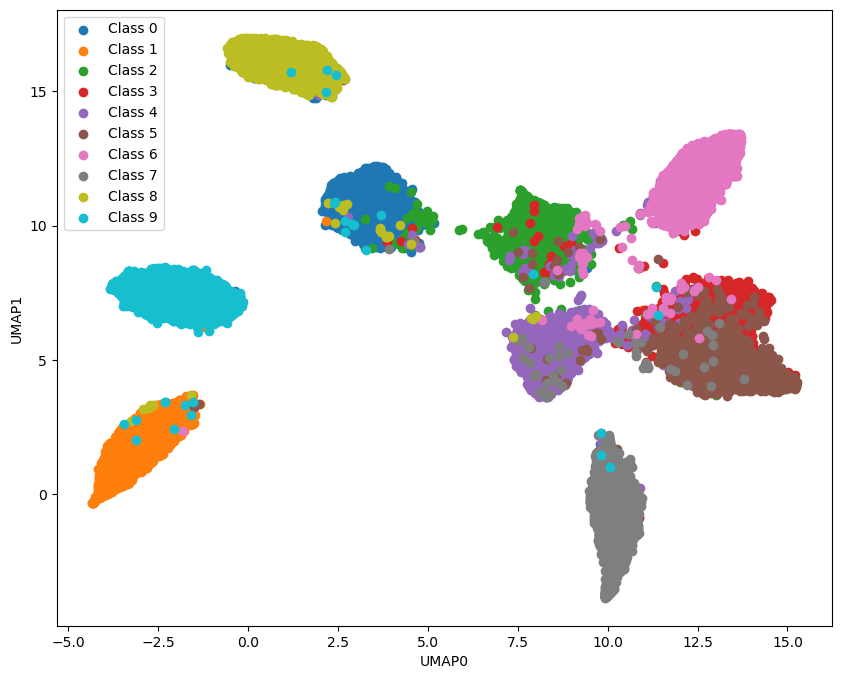

In [ ]:
history = model2.fit(x_train, y_train, epochs = 50, batch_size = 32, validation_data = (x_test, y_test))
test_loss, test_acc = model2.evaluate(x_test, y_test, verbose = 1)
print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_acc)
penultimate_model = Model(inputs = model2.input, outputs = model2.layers[-2].output)
visualise_embedding(penultimate_model.predict(x_train), y = y_train)

A little extra setting here is, `z` is set to 10 and the epochs are reduced from 100 to 50. The model seems to have performed really well with steady increase in the training accuracy and a bit of jumps in the validation accuracy. The dimensions of the penultimate layer is reduced using UMAP for visualising the embeddings. The embeddings seems to be really good. We can see that each class is able to create their own clusters which shows a great sign of learning done by the model. Even though the cluster formation is really good, there is still some overlapping points showcasing chance for a bit more of improvement necessity. Overall, there is still a room for improvement but the model has done really well in understanding the data and in seggragating some of the classes. The performance of this setting of model / parameters is better than the previous ones. Also, the test accuracy is 71% which is a good accuracy. Despite the image being shrinked this small to 4x4, the model is able to perform well.

# Pre-Trained Model
### Xception model

Epoch 1/20
782/782 [==============================] - 211s 266ms/step - loss: 2.2998 - accuracy: 0.1199 - val_loss: 2.2964 - val_accuracy: 0.1410
Epoch 2/20
782/782 [==============================] - 203s 259ms/step - loss: 2.2913 - accuracy: 0.1480 - val_loss: 2.2866 - val_accuracy: 0.1638
Epoch 3/20
782/782 [==============================] - 216s 276ms/step - loss: 2.2779 - accuracy: 0.1741 - val_loss: 2.2709 - val_accuracy: 0.1875
Epoch 4/20
782/782 [==============================] - 217s 278ms/step - loss: 2.2548 - accuracy: 0.1968 - val_loss: 2.2381 - val_accuracy: 0.2161
Epoch 5/20
782/782 [==============================] - 216s 277ms/step - loss: 2.2048 - accuracy: 0.2303 - val_loss: 2.1640 - val_accuracy: 0.2551
Epoch 6/20
782/782 [==============================] - 214s 274ms/step - loss: 2.1134 - accuracy: 0.2612 - val_loss: 2.0576 - val_accuracy: 0.2764
Epoch 7/20
782/782 [==============================] - 3720s 5s/step - loss: 2.0153 - accuracy: 0.2841 - val_loss: 1.9687 - v

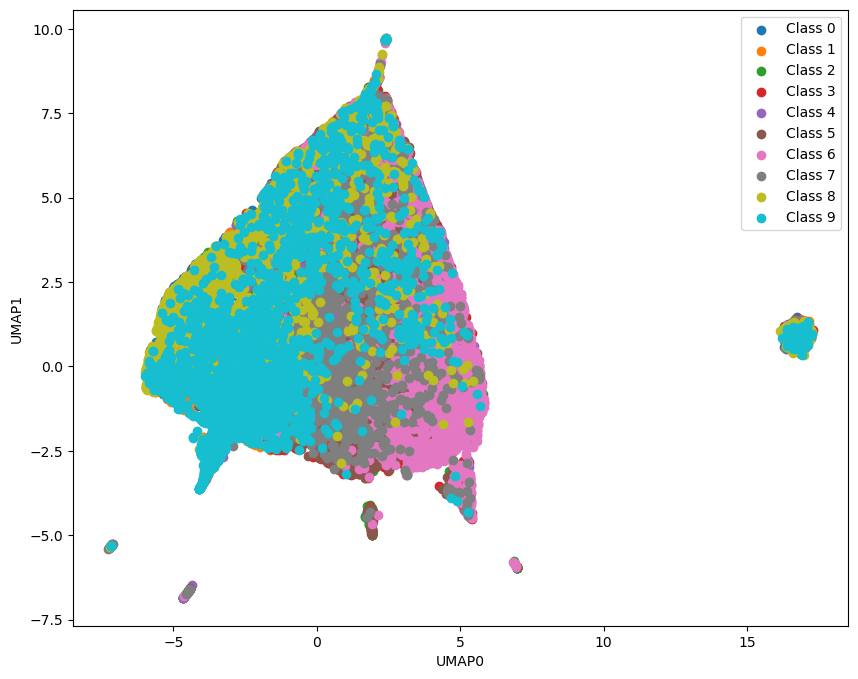

In [ ]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
Xception_model = Xception(include_top = False, weights = 'imagenet', input_tensor = Input(shape = (32, 32, 3)))
for layer in Xception_model.layers:
    layer.trainable = False
x = Xception_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation = 'relu')(x)
x = Dense(224, activation = 'relu')(x)
x = Dense(128, activation = 'relu')(x)
x = Dense(64, activation = 'relu')(x)
preds = Dense(10, activation = 'softmax')(x)
pre_trained_model = Model(inputs = Xception_model.input, outputs = preds)
datagen = ImageDataGenerator(preprocessing_function = lambda x: tf.image.resize(x, (32, 32)))
train_gen = datagen.flow(x_train, y_train, batch_size = 32)
validation_gen = datagen.flow(x_test, y_test, batch_size = 32)
pre_trained_model.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = pre_trained_model.fit(train_gen, epochs = 20, validation_data = validation_gen)
test_loss, test_acc = pre_trained_model.evaluate(validation_gen, verbose = 1)
print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_acc)
penultimate_model = Model(inputs = pre_trained_model.input, outputs = pre_trained_model.layers[-2].output)
visualise_embedding(penultimate_model.predict(x_train), y = y_train)

I have used the Xception pre-trained model. The Xception model was trained with four dense layers with the neurons 512, 224, 128 and 64. The optimizer is yet again `SGD`. After training the model for 20 epochs, the model was able to give accuracy around 40%. The training accuracy is increasing gradually while the validation accuracy seems to be jumping slightly. There is a room for improvement here also. Perhaps training for more epochs will help, as the jumps arent that bad and the accuracy is increasing. The Xception model usually expects 299x299 image size as input, but the model is feasible to work with different sizes too. Also resizing an image from 32x32 to 299x299 might lead to lot of distortion in the image leading to poor image quality which will further lead to poor classification. In the embedding plot we can see that most of the points are populated in the center. Most of the points are centered in the plot with so much overlapping happening, which shows that the model is not doing a good job at distinguishing classes. There are also points spreaded in distance from the group in the middle, so for some points the model is able to distinguish to some extent. Overall, there is a great room for improvement like adding extra layers or training for extra epochs etc.


#### Reference

1. https://github.com/hokmund/xception-transfer-learning/blob/master/transfer-learning.ipynb
2. https://datascience.stackexchange.com/questions/89860/input-shape-of-an-xception-cnn-model#:~:text=For%20your%20first%20question%2C%20yes,that%20would%20be%20the%20best.